Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time:<br>
Instructor Name: Morgan Jones<br>
Blog post URL:

# Project Description

The World Health Organization (WHO) estimates that 2 million children below the age of 5 die from pneumonia every year, making it the leading cause of child mortality worldwide. The vast majority of cases and deaths are in developing countries, particularly in Africa and Southeast Asia.

Timely diagnosis of pneumonia is key for improving health outcomes for patients. It is also important to determine whether the pneumonia is caused by a bacterial or a viral infection since the treatment plans are very different depending on the cause.

One effective method of diagnosing pneumonia is by taking chest X-rays. A medical expert can identify the telltale signs of pneumonia by observing the X-rays, but some facilities in developing countries lack such an expert. This slows down the process of diagnosing the disease, leading to delays in medical intervention.

A potential solution is to create a computer model that can interpret the chest X-rays. Such a model could be made available to medical facilities across the world, helping to shorten the time it takes to diagnose pediatric pneumonia so that life-saving treatment can be provided faster.

In this project, I train a convolutional neural network (CNN) to diagnose pneumonia using a labeled set of chest X-rays.

### Data
The data used in this project was obtained from https://data.mendeley.com/datasets/rscbjbr9sj/3.

The data contains 5856 images of chest X-rays taken for children 5 years of age or younger. The images were examined by 2 medical experts to determine whether the patient has pneumonia and, if so, whether it is bacterial or viral pneumonia. A third expert validated their classifications.

The data is split into train and test directories, and each of those is split into "NORMAL" and "PNEUMONIA" directories. The images corresponding to a patient with bacterial pneumonia all start with "BACTERIA" and those with viral pneumonia start with "VIRUS". Patients without pneumonia all of images starting with "NORMAL".

Below is a breakdown of how many images there are in each directory:

train - NORMAL: 1349<br>
train - PNEUMONIA: 3883 (BACTERIA: 2538, VIRUS: 1345)<br>
test - NORMAL: 234<br>
test - PNEUMONIA: 390 (BACTERIA: 242, VIRUS: 148)

In addition to indicating whether the patient has pneumonia, the filename also includes a unique 6-digit code for each patient and a 4-digit code counting the number of images for that patient since some patients have multiple images. For example, a patient with multiple images will have their first image will end with 0001, second with 0002, and so on.

The images have a variety of dimensions and aspect ratios. They are cropped and resized to a standard size before they are input to the CNN.

Note: The zip file provided at https://data.mendeley.com/datasets/rscbjbr9sj/3 contains data of both chest X-ray images for diagnosing pneumonia and optimal coherence tomography (OCT) images for diagnosing eye conditions. I only use the chest X-ray images.

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
import os
import datetime
import matplotlib.pyplot as plt
from keras import regularizers
%matplotlib inline
plt.style.use('ggplot')

### Data Exploration

First, I just want to see how many images are in each directory

In [2]:
# Count the number of images in each directory
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        print(directory, '\t BACTERIA:',sum([1 if 'BACTERIA' in x else 0 for x in files]),
              'VIRUS:', sum([1 if 'VIRUS' in x else 0 for x in files]))
    else:
        print(directory, '\t \t NORMAL:', len(files))

train/NORMAL/ 	 	 NORMAL: 1349
train/PNEUMONIA/ 	 BACTERIA: 2538 VIRUS: 1345
test/NORMAL/ 	 	 NORMAL: 234
test/PNEUMONIA/ 	 BACTERIA: 242 VIRUS: 148


**Aspect Ratio**

The images have different dimensions and aspect ratios. I will crop and resize the images to a common size. Below, I determine what the average aspect ratio is. I will use this for the final aspect ratio.

In [3]:
# Get a list of all files
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])] + \
        [os.path.join(maindir+subdirs[1], name) for name in os.listdir(maindir+subdirs[1])] + \
        [os.path.join(maindir+subdirs[2], name) for name in os.listdir(maindir+subdirs[2])] + \
        [os.path.join(maindir+subdirs[3], name) for name in os.listdir(maindir+subdirs[3])]

img_dims = []
for img_path in names:
    if 'jpeg' in img_path:
        img = load_img(img_path, color_mode='grayscale')
        img_dims.append([img.height,img.width])
img_dims = np.array(img_dims)

0.7147827266780963


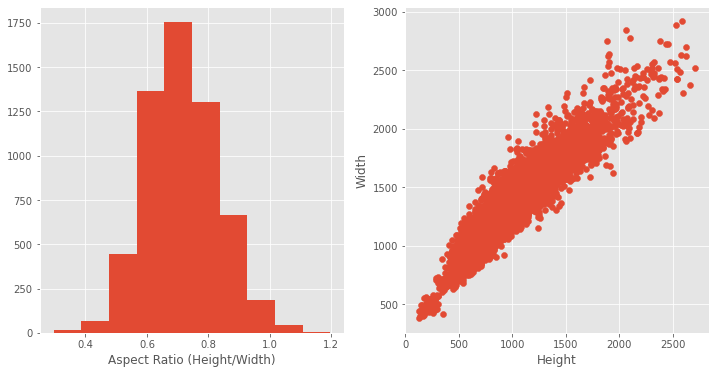

In [4]:
# Plot a histogram of aspect ratio and scatter plot of height and width
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

aspect_ratios = img_dims[:,0]/img_dims[:,1]
mean_aspect = np.mean(aspect_ratios)
print(mean_aspect)
ax[0].hist(aspect_ratios)
ax[0].set_xlabel('Aspect Ratio (Height/Width)')
ax[1].scatter(img_dims[:,0],img_dims[:,1])
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Width');

The mean aspect ratio is 0.715. I will use this aspect ratio when I create the tensors for use in the CNN models.

**Cropping and Resizing**

Below, I create a function that will read in an image, crop it, and resize it. The function also gives an option for rescaling, which is useful because CNN models tend to converge better if the values are between 0 and 1.

I could just resize without cropping, but this would result in stretching the image either vertically or horizontally if the aspect ratio is not equal to the aspect ratio of the desired dimensions. By cropping first, I avoid stretching the images.

The way I crop the images is by checking whether the image is too tall or too wide (compared to the average aspect ratio). If it is too tall, I will crop equal amounts from the top and bottom of the image to achieve the desired aspect ratio. If it is too wide, I crop equal amounts from the left and right. I tested this on a few images and the parts of images that get cut out should not be important for diagnosing pneumonia. The lungs are what matters and they don't get cropped out using the function below.

In [5]:
def crop_resize_image(filepath, dims=None, rescale=None):
    """
    Reads in an image, crops it, and resizes it so that the final array has dimensions dims.
    Input:
    filepath: Full directory path to image.
    dims: Desired dimensions of image as tuple. Default is None, in which case no cropping or resizing is done.
    rescale: Number by which to multiply the image. Default is to not rescale.
    """
    img = load_img(filepath, color_mode='grayscale')
    if dims == None:
        img_array = img_to_array(img)
    # Crop and resize if dims is specified
    else:
        desired_aspect = dims[0]/dims[1]
        if img.height/img.width > desired_aspect:
            desired_height = img.width * desired_aspect
            cut = np.round((img.height - desired_height)/2,0)
            img_crop = img.crop((0,cut,img.width,img.height-cut))
        else:
            desired_width = img.height / desired_aspect
            cut = np.round((img.width - desired_width)/2,0)
            img_crop = img.crop((cut,0,img.width-cut,img.height))
        img_resize = img_crop.resize((dims[1],dims[0]))
        img_array = img_to_array(img_resize)
        
    # Rescale the image if rescale is defined
    if rescale != None:
        img_array *= rescale
        
    return img_array[:,:,0]

In [6]:
# Try out the function above
directory = maindir + subdirs[0]
files = [x for x in os.listdir(directory) if 'jpeg' in x]
# Desired width of images
width = 180
# Dimensions use mean aspect ratio.
dimensions = (int(np.round(mean_aspect*width,0)), width)
img_array = crop_resize_image(directory+files[6], dimensions, 1/255)
img_array.shape

(129, 180)

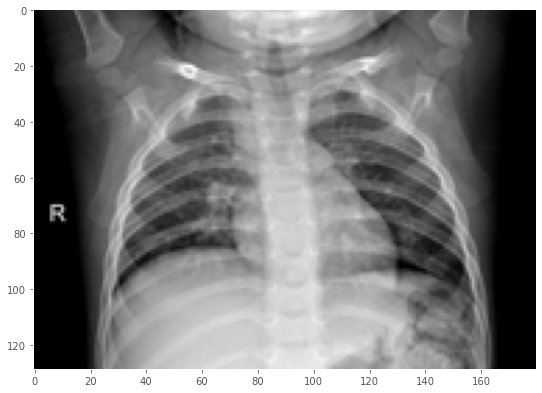

In [7]:
# Display an image after it has been cropped and resized
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(img_array, cmap='gray')
ax.grid(False)

The image above was cropped and resized to the desired dimensions. The image is not stretched or shrunk even though the original aspect ratio of the image might not have been the same as the final aspect ratio.

**Functions for Preparing Data**

The function below is used to get samples of images. The function allows the user to specify how many images to collect and whether you want one or two samples (useful for creating train and validation splits)

In [8]:
def get_image_filenames(rootdir, subdir, size='all', size2=0):
    """
    This function collects filenames of images.
    Input:
    rootdir: The directory that contains all of the data.
    subdir: Indicates whether to collect images from 'train' or 'test'.
    size: Number of images to collect. Default is collect all the images.
    size2: If indicated, it is the number of images to collect for a second sample.
        This is useful for creating a validation sample which won't overlap with the training sample.2
        
    Output:
    One list of files and one list of labels (if size2=0) or two lists of files and two lists of labels if size2>0.
    """
    # Get image names from NORMAL
    directory = rootdir + subdir + '/NORMAL/'
    files_normal = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    # Get image names from PNEUMONIA
    directory = rootdir + subdir + '/PNEUMONIA/'
    files_pneum = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    files_bacteria = [x for x in files_pneum if 'BACTERIA' in x]
    files_virus = [x for x in files_pneum if 'VIRUS' in x]

    # Check to make sure we did not ask for more files than exist in the directories
    if size != 'all':
        check = (len(files_normal) >= size+size2) * (len(files_bacteria) >= size+size2) * (len(files_virus) >= size+size2)
        if check == False:
            raise Exception('Asked for more images than are actually present')
    
    if size == 'all':
        filenames = np.append(files_normal, np.append(files_bacteria, files_virus))

        return filenames

    else:
        sample_normal = np.random.choice(files_normal, size+size2, replace=False)
        sample_bacteria = np.random.choice(files_bacteria, size+size2, replace=False)
        sample_virus = np.random.choice(files_virus, size+size2, replace=False)
            
        if size2 == 0:
            filenames = np.append(sample_normal, np.append(sample_bacteria, sample_virus))

            return filenames
        else:
            filenames1 = np.append(sample_normal[0:size], np.append(sample_bacteria[0:size],sample_virus[0:size]))
            filenames2 = np.append(sample_normal[size:], np.append(sample_bacteria[size:],sample_virus[size:]))

            return filenames1, filenames2

In [9]:
def create_tensors(filenames, dims, OHE=True):
    """
    Function for turning a list of filenames into tensors that can be input to a CNN model.
    Inputs:
    filenames: List of filenames.
    dims: The desired dimensions of the output.
    OHE: Indicates whether the class labels should be one-hot encoded. Default is True.
    """
    x = np.zeros((len(filenames), dims[0], dims[1]))
    y = np.zeros(len(filenames))

    # Loop over files
    for n, file in enumerate(filenames):
        x[n] = crop_resize_image(file, dims, 1/255)
        # Determine the class of the image
        if 'NORMAL' in file:
            y[n] = 0
        elif 'BACTERIA' in file:
            y[n] = 1
        elif 'VIRUS' in file:
            y[n] = 2
        else:
            raise Exception(f"Cannot determine class for {file}")

    # One-hot encode the classes if OHE is True
    if OHE:
        y = to_categorical(y, 3)

    # Reshape x into a tensor
    x = x.reshape(-1, dims[0], dims[1], 1)
    return x, y

Below, I use the functions I have written to create train, validation, and test samples.

In [10]:
# Set random seed
np.random.seed(42)
# Size of train dataset
train_size = 500
# Size of validation dataset
val_size = 100

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test = create_tensors(test_list, dimensions, OHE=True)

In [11]:
# Import modules needed for creating a CNN model
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Building a Convolutional Neural Network

I am going to iteratively create a convolutional neural network. In order to evaluate the models, I need to look at some metrics. It will be helpful to have a function I can call that will display the metrics I care about.

The function below will create and print a classification report, a confusion matrix, and ROC curves. Since there are three classes, three ROC curves are created by considering one class vs. the others. Classification reports and confusion matrices will be created for train, validation, and test datasets. ROC curves will only be created for the test dataset.

In [12]:
def display_metrics(model, train_data=None, val_data=None, test_data=None):
    """
    Function for displaying classification reports, confusion matrices, and ROC curves.
    Classification reports and confusion matrices are created for train, validation, and test data.
    ROC curves are only created for the test data.
    
    Inputs:
    model: The fitted model.
    train_data, val_data, test_data: (x,y) tuple containing different types of data.
    Default is None, in which case no classification report or confusion matrix will be displayed.
    
    """
    # Classification reports
    
    count = 0
    
    if train_data != None:
        print("Classification Report: Train")
        print(classification_report(np.argmax(train_data[1], axis=-1),
                                    np.argmax(model.predict(train_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if val_data != None:
        print("Classification Report: Validation")
        print(classification_report(np.argmax(val_data[1], axis=-1),
                                    np.argmax(model.predict(val_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if test_data != None:
        print("Classification Report: Test")
        print(classification_report(np.argmax(test_data[1], axis=-1),
                                    np.argmax(model.predict(test_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
        
    # Confusion Matrices
    fig, ax = plt.subplots(ncols=count, figsize=(count*5,4))
    n = 0
    if train_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(train_data[1], axis=-1), np.argmax(model.predict(train_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_train = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Train')
        ax[n].grid(False)
        n += 1
    if val_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(val_data[1], axis=-1), np.argmax(model.predict(val_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_val = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Validation')
        ax[n].grid(False)
        n += 1
    if test_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(test_data[1], axis=-1), np.argmax(model.predict(test_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_test = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Test')
        ax[n].grid(False)

    fig.tight_layout()
    
    # Print binary accuracy (healthy vs. pneumonia)
    print('Binary Accuracy')
    print('Train:', round(acc_train,3))
    print('Validation:', round(acc_val,3))
    print('Test:', round(acc_test,3))
    
    # ROC curves (only test data)
    if test_data != None:
        fig2, ax2 = plt.subplots(figsize=(6,6))
        
        ax2.plot([0,1],[0,1])
        
        for i, case in enumerate(['NORMAL vs. Rest','BACTERIA vs. Rest','VIRUS vs. Rest']):
            fpr, tpr, thresh = roc_curve(test_data[1][:,i], model.predict(test_data[0])[:,i])
            ax2.plot(fpr, tpr, label=f"{case}: {round(auc(fpr, tpr),3)}")
        ax2.set_title('ROC Curve: Test Data')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()

**Iteratively Making a Model**

The way I am going to create the model is by running a model, evaluating its performance, than changing one aspect of that model for the next iteration, that way I can understand what difference that one change made. As a result, I may end up trying quite a few models. I do not want the notebook to have to rerun every single model I try when I run the notebook, so instead I will summarize the results of each model in the table in the cell below. Only the final model will be included in the final notebook, but the performance of each model will be present in the table.

### Evaluation

The table below summarizes the performance of each model.<br>
The Description column says which model was changed and how to create a new model. For example, if the table says Model 3 is "Model 2 + L2 regularization", it means that Model 3 is exactly the same as Model 2 except it uses L2 regularization.

Model 1 is described in detail below:


|Version |Description |Train Accuracy |Binary Train Accuracy |Test Accuracy |Binary Test Accuracy |AUC (healthy) |AUC (bacterial) |AUC (viral) |time (s) |

**Optimizer**

There are several optimizers I can choose to use. I am going to test out SGD, RMSprop, and Adam to see which works best.

**Model 1**

The first model will use the SGD optimizer.
The first model will contain three Conv2D layers.<br>
The first two layers have 32 3x3 filters and the third has 64 3x3 filters.<br>
A MaxPooling2D layer is used after each Conv2D layer to reduce the size of the arrays and isolate the parts of the images that match the filters best.<br>
After two convolution layers, the data is flattened and a Dense layer with 64 nodes is used.<br>
The output layer is a Dense layer with 3 nodes, one for each class.<br>

I will use categorical_crossentropy for the loss function since there are more than 2 classes.

The train data includes 1500 images (500 of each class) that are 129x180.<br>
The validation data includes 300 images (100 of each class).

In [796]:
# Model 1
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                        input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_187 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 28, 41, 64)      

In [797]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/100
75/75 [==============================] - 41s 542ms/step - loss: 1.9870 - acc: 0.3325 - val_loss: 1.4440 - val_acc: 0.3333
Epoch 2/100
75/75 [==============================] - 40s 529ms/step - loss: 1.3122 - acc: 0.3300 - val_loss: 1.2265 - val_acc: 0.3333
Epoch 3/100
75/75 [==============================] - 40s 532ms/step - loss: 1.1881 - acc: 0.3317 - val_loss: 1.1598 - val_acc: 0.3333
Epoch 4/100
75/75 [==============================] - 40s 533ms/step - loss: 1.1445 - acc: 0.3421 - val_loss: 1.1330 - val_acc: 0.3646
Epoch 5/100
75/75 [==============================] - 40s 532ms/step - loss: 1.1248 - acc: 0.4050 - val_loss: 1.1164 - val_acc: 0.3417
Epoch 6/100
75/75 [==============================] - 40s 532ms/step - loss: 1.0103 - acc: 0.4913 - val_loss: 0.9427 - val_acc: 0.6104
Epoch 7/100
75/75 [==============================] - 42s 556ms/step - loss: 0.8999 - acc: 0.5954 - val_loss: 0.8682 - val_acc: 0.6667
Epoch 8/100
75/75 [==============================] - 42s 556ms

Epoch 62/100
75/75 [==============================] - 39s 518ms/step - loss: 0.7170 - acc: 0.6971 - val_loss: 0.6510 - val_acc: 0.7375
Epoch 63/100
75/75 [==============================] - 39s 514ms/step - loss: 0.7189 - acc: 0.6954 - val_loss: 0.6426 - val_acc: 0.7312
Epoch 64/100
75/75 [==============================] - 39s 513ms/step - loss: 0.7111 - acc: 0.6917 - val_loss: 0.6858 - val_acc: 0.7250
Epoch 65/100
75/75 [==============================] - 39s 515ms/step - loss: 0.7030 - acc: 0.6929 - val_loss: 0.6538 - val_acc: 0.7250
Epoch 66/100
75/75 [==============================] - 39s 515ms/step - loss: 0.6949 - acc: 0.7021 - val_loss: 0.6652 - val_acc: 0.7271
Epoch 67/100
75/75 [==============================] - 39s 517ms/step - loss: 0.7072 - acc: 0.6971 - val_loss: 0.6635 - val_acc: 0.7271
Epoch 68/100
75/75 [==============================] - 40s 533ms/step - loss: 0.7012 - acc: 0.6971 - val_loss: 0.6611 - val_acc: 0.7188
Epoch 69/100
75/75 [==============================] - 3

In [ ]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.901     0.932     0.916       800
    BACTERIA      0.701     0.765     0.732       800
       VIRUS      0.704     0.615     0.656       800

    accuracy                          0.771      2400
   macro avg      0.769     0.771     0.768      2400
weighted avg      0.769     0.771     0.768      2400

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.914     0.931     0.923       160
    BACTERIA      0.640     0.756     0.693       160
       VIRUS      0.688     0.550     0.611       160

    accuracy                          0.746       480
   macro avg      0.747     0.746     0.742       480
weighted avg      0.747     0.746     0.742       480

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.909     0.808     0.855       234
    BACTERIA      0.838     0.789     

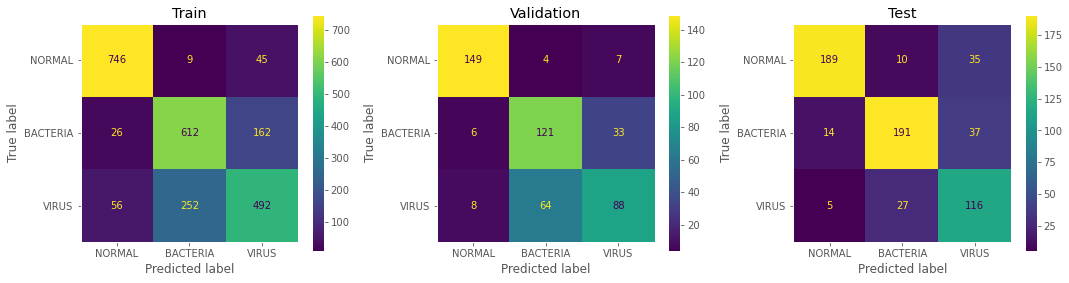

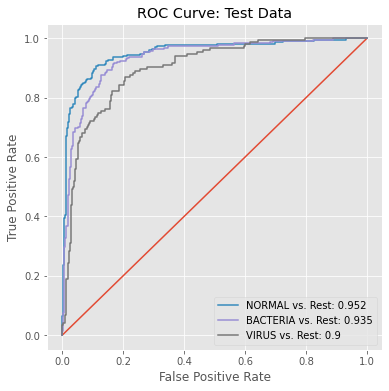

In [799]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.950     0.980     0.965       500
    BACTERIA      0.841     0.910     0.874       500
       VIRUS      0.894     0.792     0.840       500

    accuracy                          0.894      1500
   macro avg      0.895     0.894     0.893      1500
weighted avg      0.895     0.894     0.893      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.857     0.960     0.906       100
    BACTERIA      0.707     0.700     0.704       100
       VIRUS      0.674     0.600     0.635       100

    accuracy                          0.753       300
   macro avg      0.746     0.753     0.748       300
weighted avg      0.746     0.753     0.748       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.921     0.846     0.882       234
    BACTERIA      0.826     0.802     

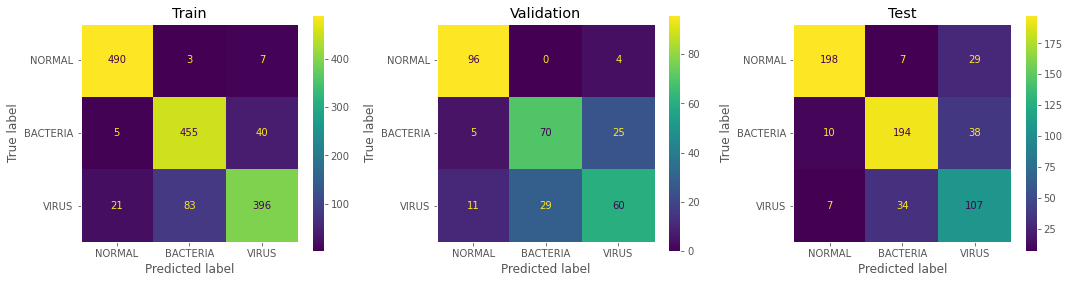

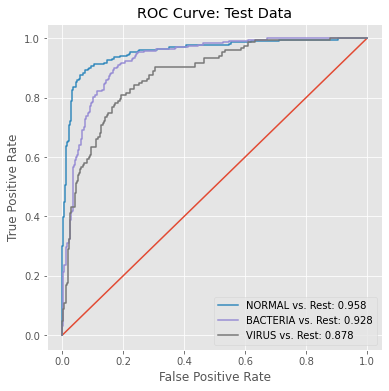

In [794]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.936     0.972     0.954       500
    BACTERIA      0.834     0.884     0.858       500
       VIRUS      0.856     0.772     0.812       500

    accuracy                          0.876      1500
   macro avg      0.875     0.876     0.875      1500
weighted avg      0.875     0.876     0.875      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.855     0.940     0.895       100
    BACTERIA      0.684     0.670     0.677       100
       VIRUS      0.685     0.630     0.656       100

    accuracy                          0.747       300
   macro avg      0.741     0.747     0.743       300
weighted avg      0.741     0.747     0.743       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.899     0.838     0.867       234
    BACTERIA      0.826     0.822     

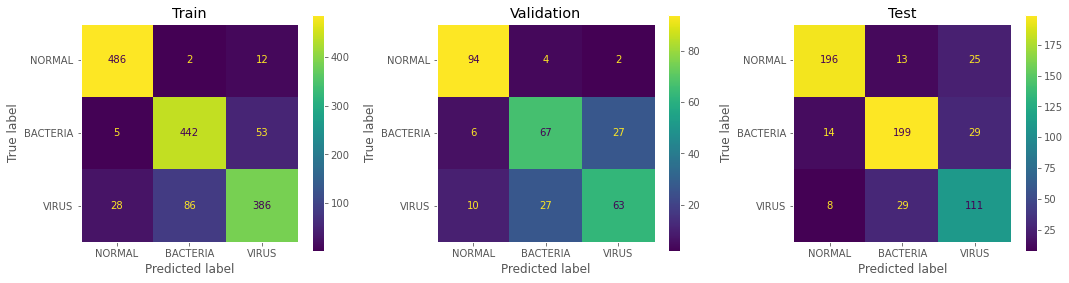

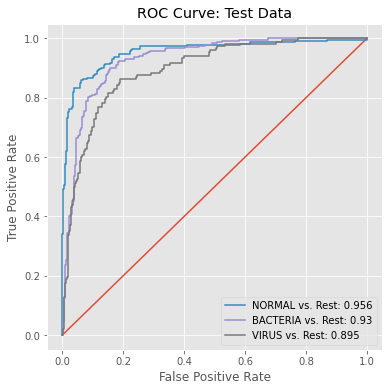

In [790]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.994     1.000     0.997       500
    BACTERIA      0.992     0.978     0.985       500
       VIRUS      0.978     0.986     0.982       500

    accuracy                          0.988      1500
   macro avg      0.988     0.988     0.988      1500
weighted avg      0.988     0.988     0.988      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.880     0.950     0.913       100
    BACTERIA      0.691     0.670     0.680       100
       VIRUS      0.642     0.610     0.626       100

    accuracy                          0.743       300
   macro avg      0.737     0.743     0.740       300
weighted avg      0.737     0.743     0.740       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.961     0.838     0.895       234
    BACTERIA      0.848     0.810     

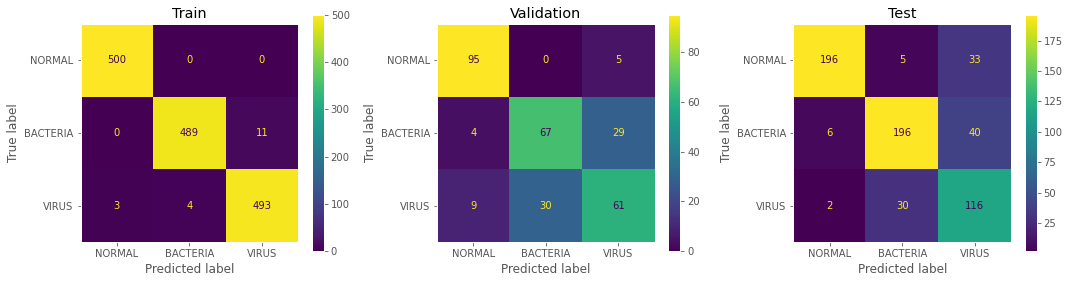

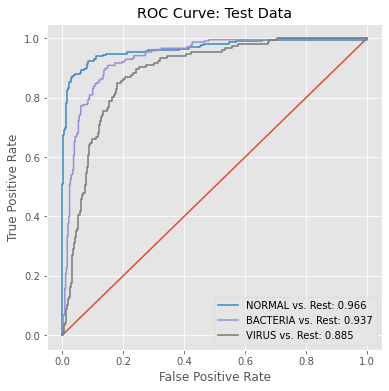

In [778]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      1.000     1.000     1.000       500
    BACTERIA      1.000     1.000     1.000       500
       VIRUS      1.000     1.000     1.000       500

    accuracy                          1.000      1500
   macro avg      1.000     1.000     1.000      1500
weighted avg      1.000     1.000     1.000      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.905     0.950     0.927       100
    BACTERIA      0.725     0.660     0.691       100
       VIRUS      0.673     0.700     0.686       100

    accuracy                          0.770       300
   macro avg      0.768     0.770     0.768       300
weighted avg      0.768     0.770     0.768       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.961     0.842     0.897       234
    BACTERIA      0.836     0.781     

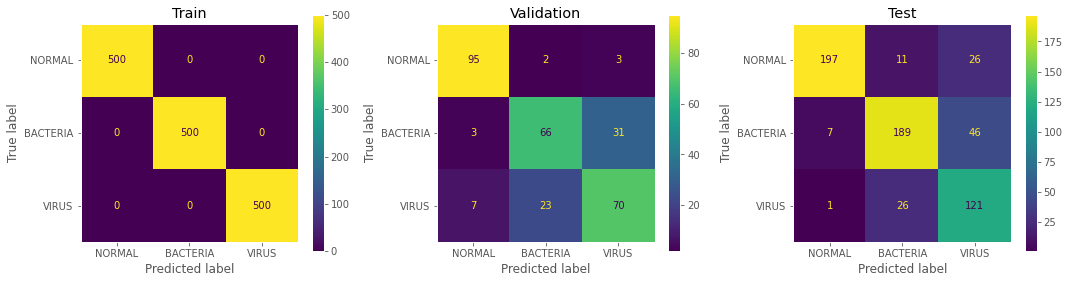

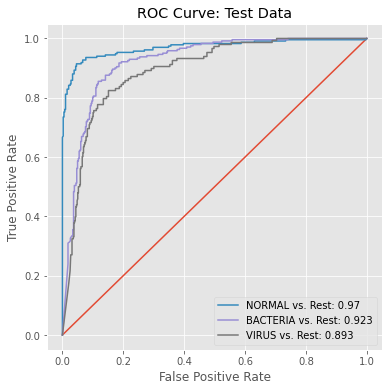

In [774]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.896     0.968     0.931       500
    BACTERIA      0.870     0.564     0.684       500
       VIRUS      0.664     0.844     0.743       500

    accuracy                          0.792      1500
   macro avg      0.810     0.792     0.786      1500
weighted avg      0.810     0.792     0.786      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.838     0.980     0.903       100
    BACTERIA      0.803     0.530     0.639       100
       VIRUS      0.641     0.750     0.691       100

    accuracy                          0.753       300
   macro avg      0.761     0.753     0.744       300
weighted avg      0.761     0.753     0.744       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.893     0.859     0.876       234
    BACTERIA      0.916     0.628     

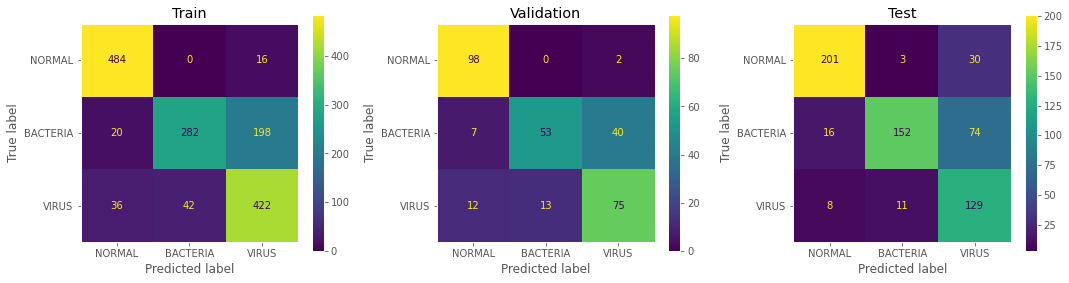

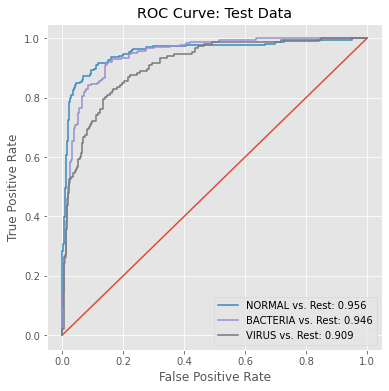

In [770]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Model 1 achieved an accuracy of 79.8% on the test data.<br>
The model performs best on the NORMAL images (92% precision and 83% accuracy).<br>
The model struggles more on the VIRAL images (63% precision and 75% accuracy).<br>

The model is not overfitting as the loss and accuracy are very similar for the train, validation, and test datasets.<br>
However, it may need more epochs to actually converge.

**Model 2**

This model is the same as model 1, except it will use the RMSprop optimizer.

In [741]:
# Model 2
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 17920)           

In [742]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/50
47/47 [==============================] - 20s 429ms/step - loss: 1.0935 - acc: 0.4200 - val_loss: 0.9403 - val_acc: 0.5800
Epoch 2/50
47/47 [==============================] - 20s 418ms/step - loss: 0.8400 - acc: 0.5973 - val_loss: 0.7585 - val_acc: 0.6667
Epoch 3/50
47/47 [==============================] - 20s 419ms/step - loss: 0.7420 - acc: 0.6580 - val_loss: 1.4010 - val_acc: 0.3767
Epoch 4/50
47/47 [==============================] - 20s 421ms/step - loss: 0.6964 - acc: 0.6740 - val_loss: 0.7519 - val_acc: 0.6567
Epoch 5/50
47/47 [==============================] - 20s 435ms/step - loss: 0.6460 - acc: 0.7180 - val_loss: 0.6404 - val_acc: 0.7300
Epoch 6/50
47/47 [==============================] - 21s 437ms/step - loss: 0.6197 - acc: 0.7293 - val_loss: 0.6413 - val_acc: 0.7500
Epoch 7/50
47/47 [==============================] - 20s 421ms/step - loss: 0.5682 - acc: 0.7540 - val_loss: 0.5857 - val_acc: 0.7500
Epoch 8/50
47/47 [==============================] - 21s 437ms/step - 

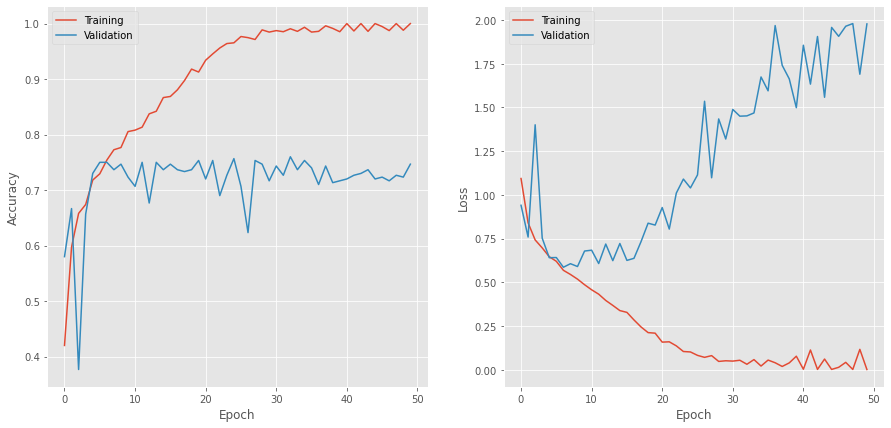

In [743]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      1.000     1.000     1.000       500
    BACTERIA      1.000     1.000     1.000       500
       VIRUS      1.000     1.000     1.000       500

    accuracy                          1.000      1500
   macro avg      1.000     1.000     1.000      1500
weighted avg      1.000     1.000     1.000      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.891     0.900     0.896       100
    BACTERIA      0.698     0.670     0.684       100
       VIRUS      0.650     0.670     0.660       100

    accuracy                          0.747       300
   macro avg      0.746     0.747     0.746       300
weighted avg      0.746     0.747     0.746       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.931     0.812     0.868       234
    BACTERIA      0.828     0.777     

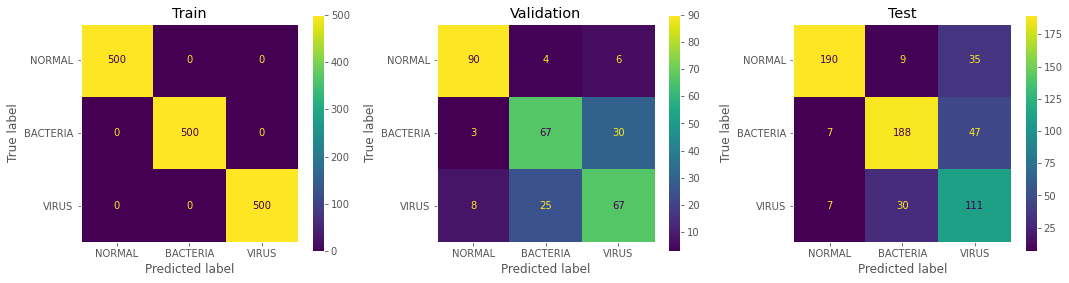

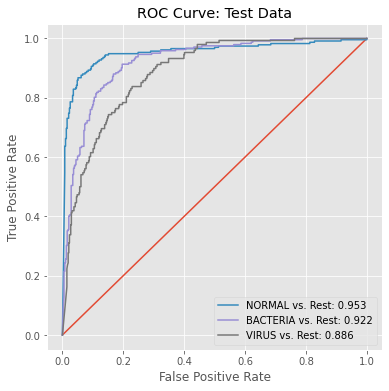

In [744]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

This model suffers from severe overfitting. The accuracy on the training data was perfect. However, the performance on the validation and test sets was still quite good. The binary accuracy was actually better as was the performance on the viral pneumonia cases. It is worth looking at whether some regularization or Dropout layers could solve the overfitting for this optimizer.

**Model 3**

The last optimizer I try is the Adam optimizer.

In [745]:
# Model 3
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 17920)           

In [746]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/50
47/47 [==============================] - 20s 419ms/step - loss: 0.9937 - acc: 0.4740 - val_loss: 0.7102 - val_acc: 0.6533
Epoch 2/50
47/47 [==============================] - 20s 425ms/step - loss: 0.7021 - acc: 0.6720 - val_loss: 0.7049 - val_acc: 0.6367
Epoch 3/50
47/47 [==============================] - 20s 420ms/step - loss: 0.6407 - acc: 0.7100 - val_loss: 0.6230 - val_acc: 0.7267
Epoch 4/50
47/47 [==============================] - 20s 420ms/step - loss: 0.5978 - acc: 0.7327 - val_loss: 0.5569 - val_acc: 0.7633
Epoch 5/50
47/47 [==============================] - 20s 425ms/step - loss: 0.5712 - acc: 0.7440 - val_loss: 0.7784 - val_acc: 0.6633
Epoch 6/50
47/47 [==============================] - 21s 447ms/step - loss: 0.5437 - acc: 0.7680 - val_loss: 0.5404 - val_acc: 0.7733
Epoch 7/50
47/47 [==============================] - 20s 420ms/step - loss: 0.5173 - acc: 0.7733 - val_loss: 0.7208 - val_acc: 0.6967
Epoch 8/50
47/47 [==============================] - 20s 416ms/step - 

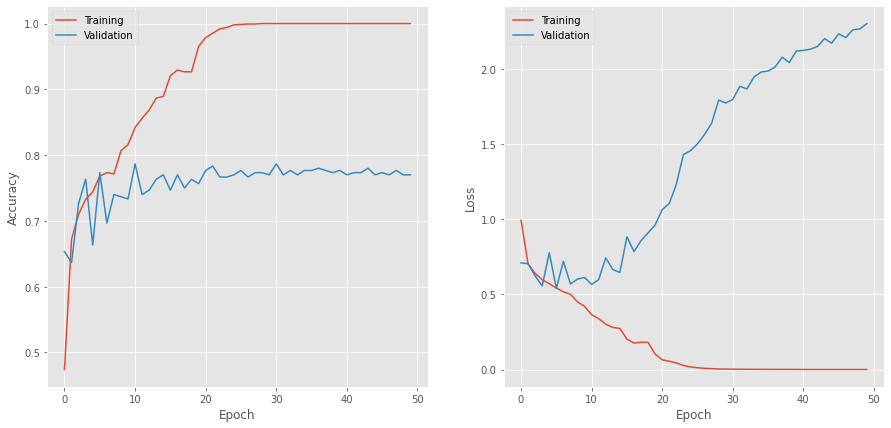

In [747]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      1.000     1.000     1.000       500
    BACTERIA      1.000     1.000     1.000       500
       VIRUS      1.000     1.000     1.000       500

    accuracy                          1.000      1500
   macro avg      1.000     1.000     1.000      1500
weighted avg      1.000     1.000     1.000      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.887     0.940     0.913       100
    BACTERIA      0.719     0.690     0.704       100
       VIRUS      0.694     0.680     0.687       100

    accuracy                          0.770       300
   macro avg      0.766     0.770     0.768       300
weighted avg      0.766     0.770     0.768       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.937     0.829     0.880       234
    BACTERIA      0.816     0.769     

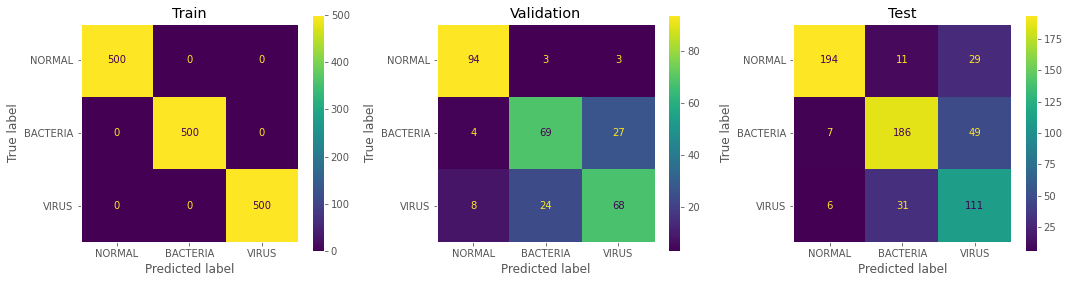

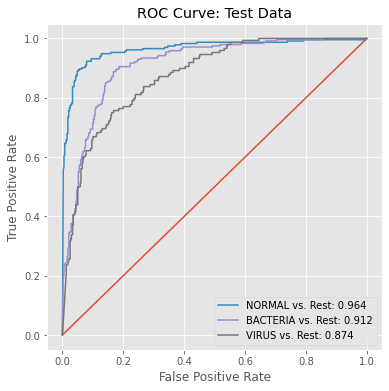

In [748]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Just like Model 2, which used the RMSprop optimizer, this model severely overfitted with perfect accuracy on the training data. Adam got slightly better accuracy on test data, so I will try using some techniques to reduce the overfitting on this model. I will not use RMSprop from now on.

**Model 4**

I am going to return to the Adam optimizer, but this time I am going to try to use dropout layers to reduce overfitting.

In [749]:
# Model 4
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_142 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 28, 41, 64)      

In [750]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/50
47/47 [==============================] - 23s 496ms/step - loss: 1.1212 - acc: 0.4047 - val_loss: 1.0672 - val_acc: 0.3367
Epoch 2/50
47/47 [==============================] - 24s 521ms/step - loss: 0.9108 - acc: 0.5387 - val_loss: 0.8228 - val_acc: 0.6433
Epoch 3/50
47/47 [==============================] - 24s 513ms/step - loss: 0.7756 - acc: 0.6367 - val_loss: 0.7900 - val_acc: 0.6633
Epoch 4/50
47/47 [==============================] - 24s 503ms/step - loss: 0.7188 - acc: 0.6553 - val_loss: 0.6741 - val_acc: 0.7167
Epoch 5/50
47/47 [==============================] - 24s 504ms/step - loss: 0.6761 - acc: 0.7000 - val_loss: 0.7766 - val_acc: 0.6700
Epoch 6/50
47/47 [==============================] - 24s 508ms/step - loss: 0.6656 - acc: 0.6907 - val_loss: 0.6916 - val_acc: 0.7233
Epoch 7/50
47/47 [==============================] - 24s 501ms/step - loss: 0.6418 - acc: 0.7073 - val_loss: 0.6702 - val_acc: 0.7133
Epoch 8/50
47/47 [==============================] - 25s 529ms/step - 

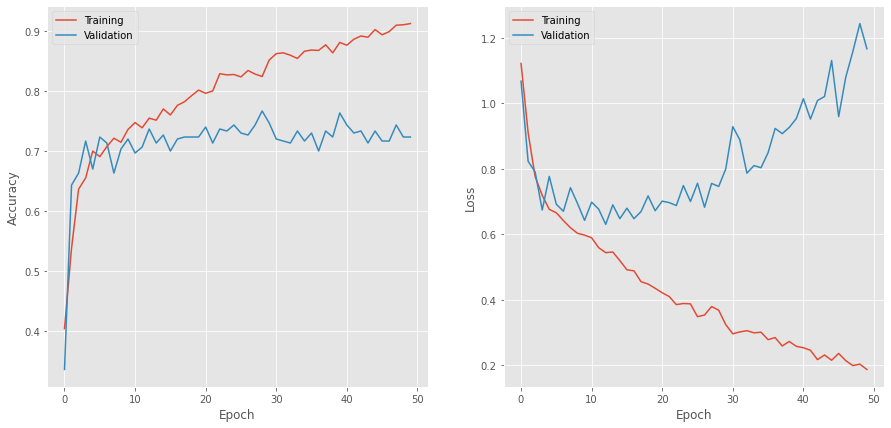

In [751]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.988     0.986     0.987       500
    BACTERIA      0.933     0.952     0.943       500
       VIRUS      0.937     0.920     0.928       500

    accuracy                          0.953      1500
   macro avg      0.953     0.953     0.953      1500
weighted avg      0.953     0.953     0.953      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.857     0.900     0.878       100
    BACTERIA      0.670     0.690     0.680       100
       VIRUS      0.630     0.580     0.604       100

    accuracy                          0.723       300
   macro avg      0.719     0.723     0.721       300
weighted avg      0.719     0.723     0.721       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.944     0.799     0.866       234
    BACTERIA      0.834     0.769     

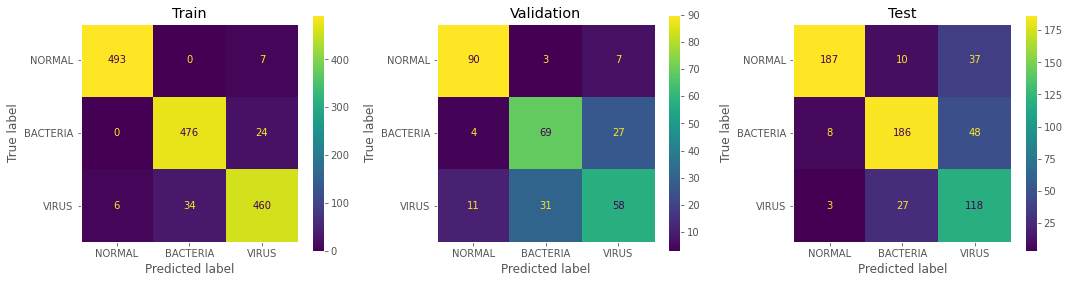

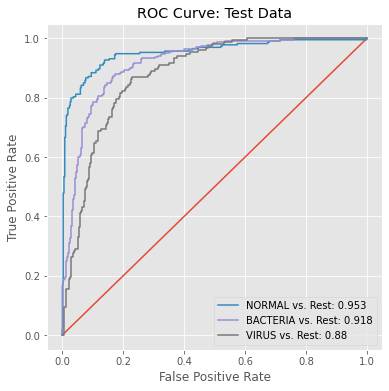

In [752]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

The Dropout layers did not put much of a dent into the overfitting.

Let's try kernel regularization next.

**Model 5**

Instead of using Dropout layers, let's try kernel regularization. I will use L2 regularization..

In [753]:
# Model 5
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                        input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                        input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 17920)           

In [754]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/50
47/47 [==============================] - 20s 418ms/step - loss: 1.2984 - acc: 0.4400 - val_loss: 1.1126 - val_acc: 0.5533
Epoch 2/50
47/47 [==============================] - 19s 409ms/step - loss: 0.9395 - acc: 0.6140 - val_loss: 0.8622 - val_acc: 0.6733
Epoch 3/50
47/47 [==============================] - 19s 406ms/step - loss: 0.7778 - acc: 0.6860 - val_loss: 0.7314 - val_acc: 0.7167
Epoch 4/50
47/47 [==============================] - 19s 409ms/step - loss: 0.7265 - acc: 0.7067 - val_loss: 0.7492 - val_acc: 0.6867
Epoch 5/50
47/47 [==============================] - 19s 403ms/step - loss: 0.6773 - acc: 0.7333 - val_loss: 0.6619 - val_acc: 0.7933
Epoch 6/50
47/47 [==============================] - 19s 406ms/step - loss: 0.6389 - acc: 0.7527 - val_loss: 0.6550 - val_acc: 0.7600
Epoch 7/50
47/47 [==============================] - 19s 409ms/step - loss: 0.6066 - acc: 0.7573 - val_loss: 0.6284 - val_acc: 0.7767
Epoch 8/50
47/47 [==============================] - 20s 429ms/step - 

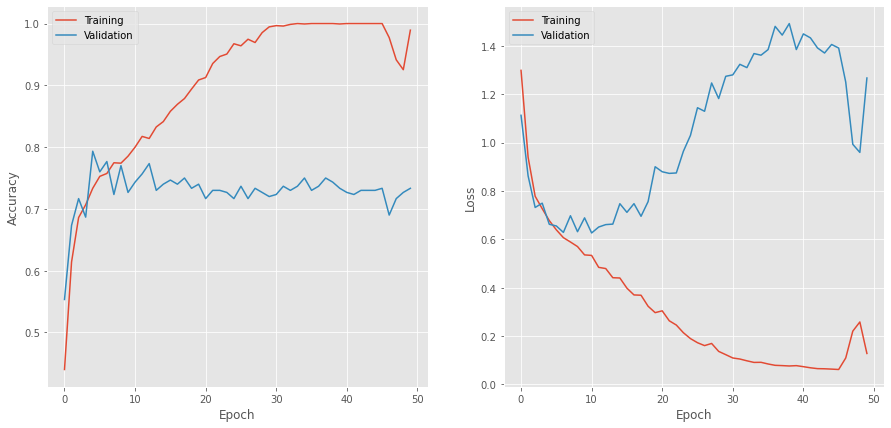

In [756]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      1.000     0.996     0.998       500
    BACTERIA      1.000     0.986     0.993       500
       VIRUS      0.982     1.000     0.991       500

    accuracy                          0.994      1500
   macro avg      0.994     0.994     0.994      1500
weighted avg      0.994     0.994     0.994      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.893     0.920     0.906       100
    BACTERIA      0.718     0.610     0.659       100
       VIRUS      0.598     0.670     0.632       100

    accuracy                          0.733       300
   macro avg      0.736     0.733     0.733       300
weighted avg      0.736     0.733     0.733       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.942     0.769     0.847       234
    BACTERIA      0.836     0.715     

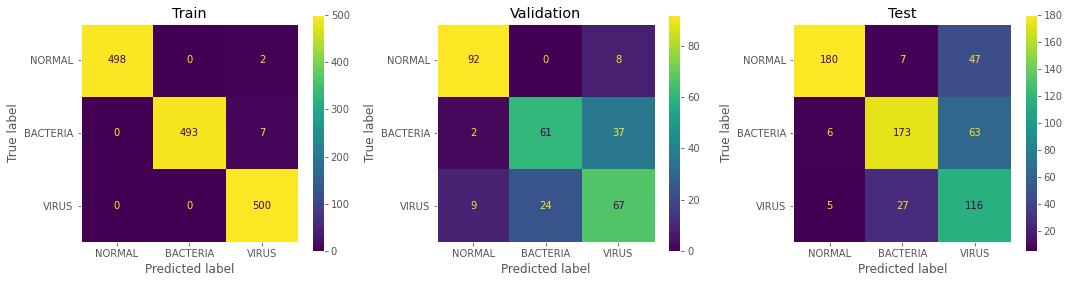

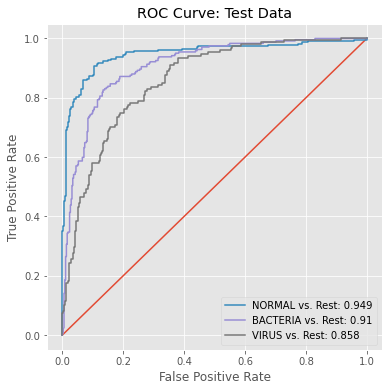

In [755]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

In [757]:
# Model 6
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 17920)           

In [758]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
47/47 [==============================] - 21s 453ms/step - loss: 1.0916 - acc: 0.3780 - val_loss: 1.0881 - val_acc: 0.3367
Epoch 2/75
47/47 [==============================] - 21s 443ms/step - loss: 1.0776 - acc: 0.4400 - val_loss: 1.0619 - val_acc: 0.6067
Epoch 3/75
47/47 [==============================] - 21s 442ms/step - loss: 1.0398 - acc: 0.4833 - val_loss: 1.0048 - val_acc: 0.5533
Epoch 4/75
47/47 [==============================] - 21s 444ms/step - loss: 0.9708 - acc: 0.5367 - val_loss: 0.9644 - val_acc: 0.5033
Epoch 5/75
47/47 [==============================] - 21s 447ms/step - loss: 0.9062 - acc: 0.5493 - val_loss: 0.9383 - val_acc: 0.4633
Epoch 6/75
47/47 [==============================] - 22s 470ms/step - loss: 0.8320 - acc: 0.6027 - val_loss: 0.7665 - val_acc: 0.6400
Epoch 7/75
47/47 [==============================] - 21s 444ms/step - loss: 0.7678 - acc: 0.6347 - val_loss: 0.7353 - val_acc: 0.6700
Epoch 8/75
47/47 [==============================] - 20s 436ms/step - 

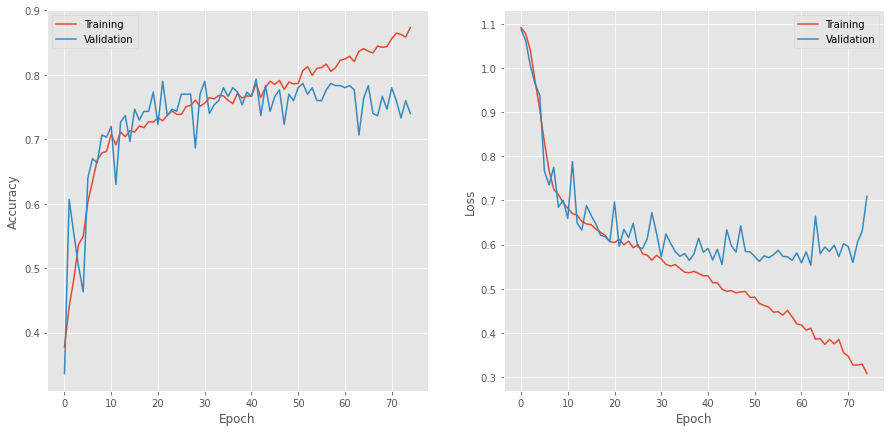

In [759]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.915     0.988     0.950       500
    BACTERIA      0.957     0.672     0.790       500
       VIRUS      0.755     0.920     0.830       500

    accuracy                          0.860      1500
   macro avg      0.876     0.860     0.856      1500
weighted avg      0.876     0.860     0.856      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.831     0.980     0.899       100
    BACTERIA      0.753     0.550     0.636       100
       VIRUS      0.633     0.690     0.660       100

    accuracy                          0.740       300
   macro avg      0.739     0.740     0.732       300
weighted avg      0.739     0.740     0.732       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.881     0.889     0.885       234
    BACTERIA      0.925     0.612     

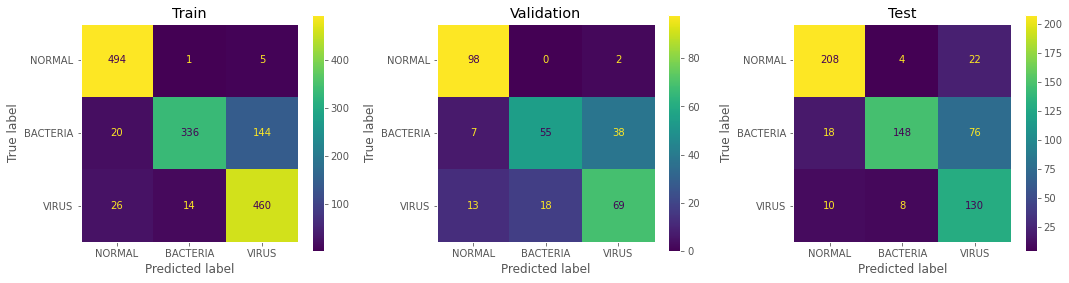

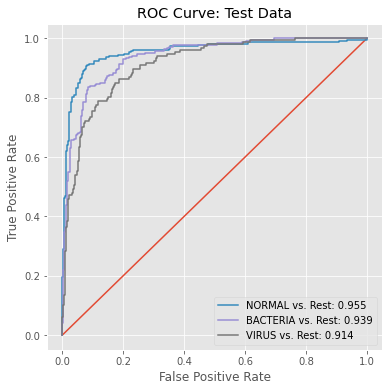

In [760]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

**Model 2**

The second model will be the same as the first except that I will introduce a third convolutional layer with 64 filters. Since there are more layers, I can use smaller MaxPooling2D kernels since I will make the images smaller three times instead of two.

In [664]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 17920)           

In [665]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/50
47/47 [==============================] - 20s 431ms/step - loss: 1.0950 - acc: 0.3647 - val_loss: 1.0918 - val_acc: 0.4567
Epoch 2/50
47/47 [==============================] - 19s 407ms/step - loss: 1.0880 - acc: 0.4207 - val_loss: 1.0820 - val_acc: 0.5633
Epoch 3/50
47/47 [==============================] - 19s 397ms/step - loss: 1.0757 - acc: 0.4887 - val_loss: 1.0649 - val_acc: 0.5633
Epoch 4/50
47/47 [==============================] - 19s 400ms/step - loss: 1.0481 - acc: 0.4687 - val_loss: 1.0214 - val_acc: 0.6200
Epoch 5/50
47/47 [==============================] - 19s 401ms/step - loss: 0.9892 - acc: 0.5473 - val_loss: 0.9301 - val_acc: 0.5667
Epoch 6/50
47/47 [==============================] - 19s 404ms/step - loss: 0.9309 - acc: 0.5427 - val_loss: 0.8452 - val_acc: 0.5833
Epoch 7/50
47/47 [==============================] - 19s 412ms/step - loss: 0.8674 - acc: 0.5760 - val_loss: 0.7830 - val_acc: 0.6767
Epoch 8/50
47/47 [==============================] - 21s 441ms/step - 

Below, I create a function for graphing the loss and accuracy as a function of epoch.

In [530]:
def plot_history(history):
    """
    Function to plot the loss and accuracy vs epoch for a model.
    Input is the history of a model.
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(acc))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax[0].plot(epoch, acc, label='Training')
    ax[0].plot(epoch, val_acc, label='Validation')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(epoch, loss, label='Training')
    ax[1].plot(epoch, val_loss, label='Validation')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

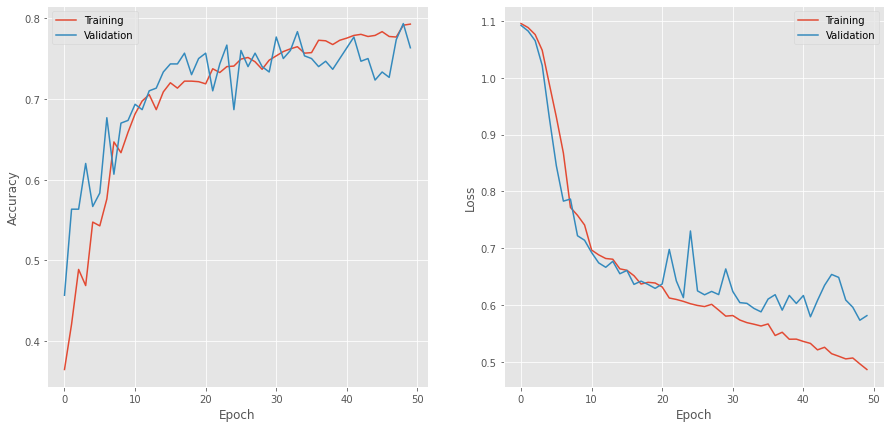

In [666]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.891     0.952     0.921       500
    BACTERIA      0.698     0.840     0.762       500
       VIRUS      0.797     0.580     0.671       500

    accuracy                          0.791      1500
   macro avg      0.795     0.791     0.785      1500
weighted avg      0.795     0.791     0.785      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.850     0.960     0.901       100
    BACTERIA      0.678     0.780     0.726       100
       VIRUS      0.764     0.550     0.640       100

    accuracy                          0.763       300
   macro avg      0.764     0.763     0.756       300
weighted avg      0.764     0.763     0.756       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.900     0.842     0.870       234
    BACTERIA      0.796     0.872     

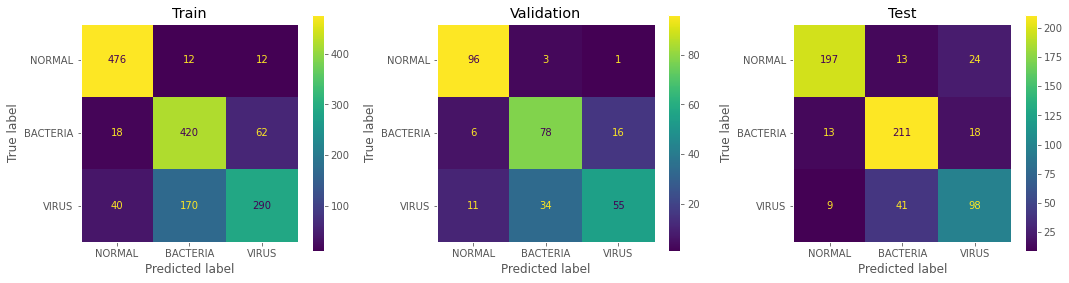

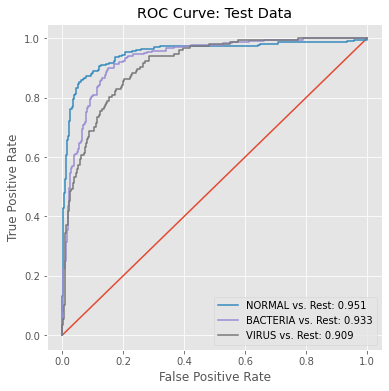

In [667]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

**Model 3**

The last model did not converge in 50 epochs. I will try 75 epochs. Everything else stays the same.

In [668]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 17920)           

In [669]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
47/47 [==============================] - 20s 416ms/step - loss: 1.0826 - acc: 0.3980 - val_loss: 1.0657 - val_acc: 0.4967
Epoch 2/75
47/47 [==============================] - 20s 430ms/step - loss: 1.0378 - acc: 0.4907 - val_loss: 0.9896 - val_acc: 0.5433
Epoch 3/75
47/47 [==============================] - 20s 419ms/step - loss: 0.9726 - acc: 0.5407 - val_loss: 1.0005 - val_acc: 0.4067
Epoch 4/75
47/47 [==============================] - 20s 421ms/step - loss: 0.8941 - acc: 0.5693 - val_loss: 0.8505 - val_acc: 0.5467
Epoch 5/75
47/47 [==============================] - 19s 407ms/step - loss: 0.8212 - acc: 0.6007 - val_loss: 0.7742 - val_acc: 0.5700
Epoch 6/75
47/47 [==============================] - 19s 407ms/step - loss: 0.7642 - acc: 0.6413 - val_loss: 0.9891 - val_acc: 0.5733
Epoch 7/75
47/47 [==============================] - 19s 407ms/step - loss: 0.7342 - acc: 0.6593 - val_loss: 0.7130 - val_acc: 0.6733
Epoch 8/75
47/47 [==============================] - 19s 413ms/step - 

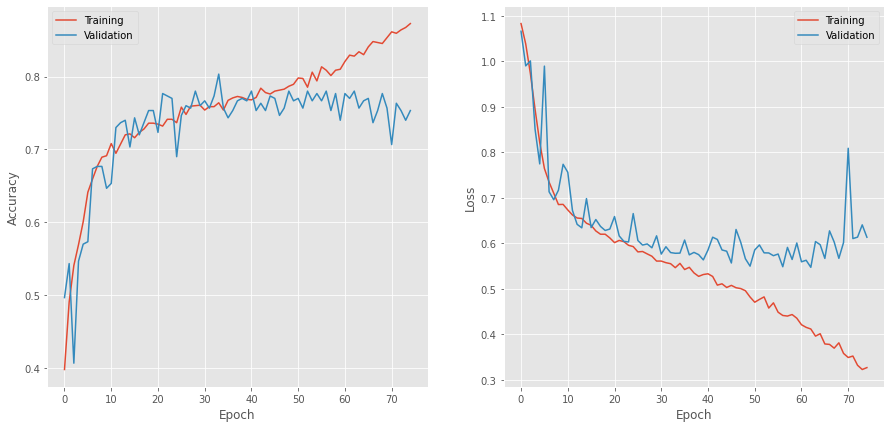

In [670]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.963     0.984     0.973       500
    BACTERIA      0.921     0.814     0.864       500
       VIRUS      0.828     0.906     0.865       500

    accuracy                          0.901      1500
   macro avg      0.904     0.901     0.901      1500
weighted avg      0.904     0.901     0.901      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.865     0.960     0.910       100
    BACTERIA      0.738     0.620     0.674       100
       VIRUS      0.648     0.680     0.663       100

    accuracy                          0.753       300
   macro avg      0.750     0.753     0.749       300
weighted avg      0.750     0.753     0.749       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.916     0.842     0.878       234
    BACTERIA      0.854     0.752     

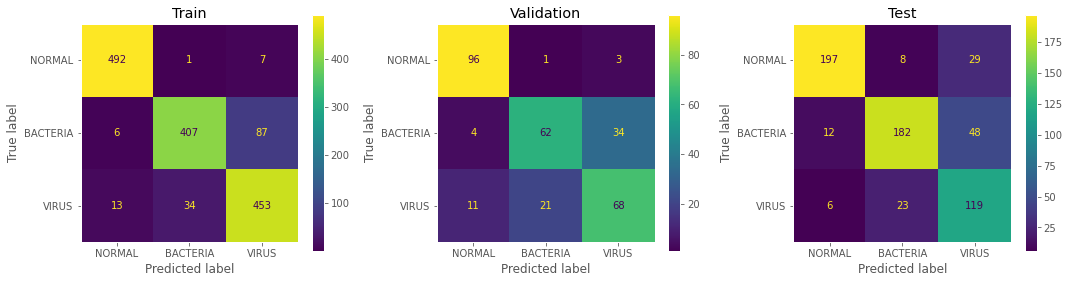

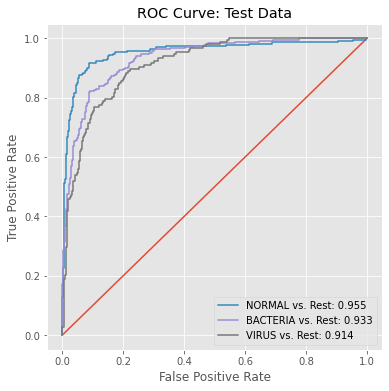

In [671]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

This model performed better on the VIRAL images, but worse on the BACTERIA images.

The model is beginning to overfit. There are several ways to address this like regularization and dropout layers.

In the next model, I will try regularization.

**Model 4**

This model will be the same as model 3 except that I introduce kernel regularization in the Conv2D and Dense layers.

In [674]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005), 
                        input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 17920)           

In [675]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
47/47 [==============================] - 21s 438ms/step - loss: 2.0984 - acc: 0.3913 - val_loss: 2.0695 - val_acc: 0.4700
Epoch 2/75
47/47 [==============================] - 21s 453ms/step - loss: 2.0414 - acc: 0.4920 - val_loss: 1.9955 - val_acc: 0.5333
Epoch 3/75
47/47 [==============================] - 19s 407ms/step - loss: 1.9678 - acc: 0.5267 - val_loss: 1.9173 - val_acc: 0.5367
Epoch 4/75
47/47 [==============================] - 19s 408ms/step - loss: 1.8795 - acc: 0.5847 - val_loss: 1.7819 - val_acc: 0.6700
Epoch 5/75
47/47 [==============================] - 20s 420ms/step - loss: 1.8030 - acc: 0.5973 - val_loss: 1.7329 - val_acc: 0.6067
Epoch 6/75
47/47 [==============================] - 19s 409ms/step - loss: 1.7499 - acc: 0.6300 - val_loss: 1.7252 - val_acc: 0.6100
Epoch 7/75
47/47 [==============================] - 19s 401ms/step - loss: 1.7006 - acc: 0.6560 - val_loss: 1.6556 - val_acc: 0.6967
Epoch 8/75
47/47 [==============================] - 19s 404ms/step - 

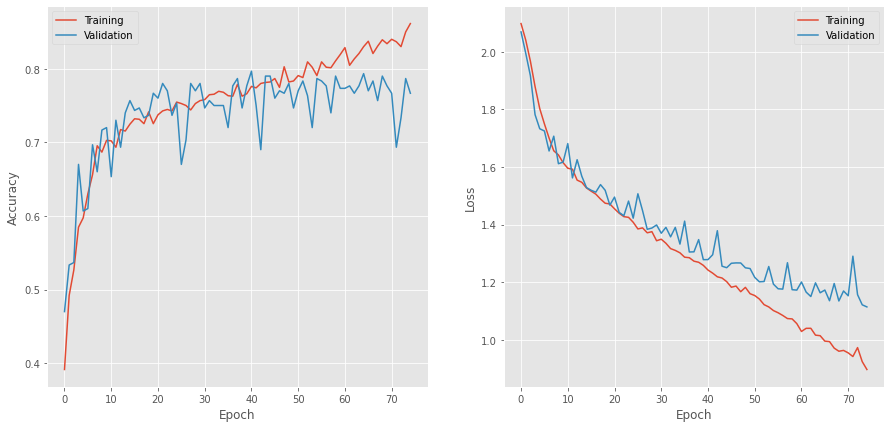

In [676]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.978     0.964     0.971       500
    BACTERIA      0.887     0.818     0.851       500
       VIRUS      0.811     0.886     0.847       500

    accuracy                          0.889      1500
   macro avg      0.892     0.889     0.890      1500
weighted avg      0.892     0.889     0.890      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.886     0.930     0.907       100
    BACTERIA      0.742     0.690     0.715       100
       VIRUS      0.667     0.680     0.673       100

    accuracy                          0.767       300
   macro avg      0.765     0.767     0.765       300
weighted avg      0.765     0.767     0.765       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.930     0.795     0.857       234
    BACTERIA      0.827     0.769     

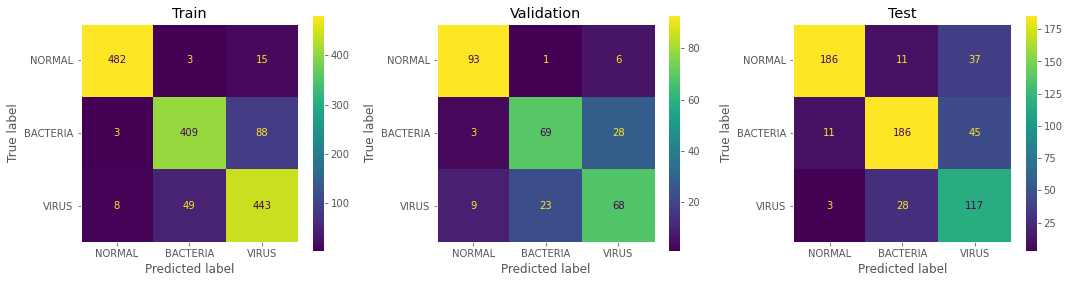

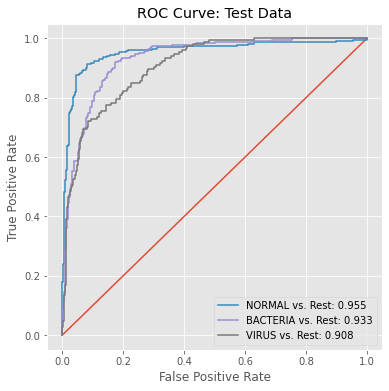

In [677]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

The L2 regularization did not prevent the overfitting and the accuracy/recall metrics got slightly worse.

**Model 5**

I will try Model 3 again but with Dropout layers. It will NOT include any regularization.

The Dropout layers will be set to 0.2.

In [678]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 28, 41, 64)      

In [679]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
47/47 [==============================] - 25s 522ms/step - loss: 1.0920 - acc: 0.3593 - val_loss: 1.0872 - val_acc: 0.5733
Epoch 2/75
47/47 [==============================] - 24s 520ms/step - loss: 1.0627 - acc: 0.4373 - val_loss: 1.0646 - val_acc: 0.3700
Epoch 3/75
47/47 [==============================] - 24s 521ms/step - loss: 1.0101 - acc: 0.4920 - val_loss: 1.0011 - val_acc: 0.6067
Epoch 4/75
47/47 [==============================] - 24s 515ms/step - loss: 0.9351 - acc: 0.5267 - val_loss: 0.9403 - val_acc: 0.6000
Epoch 5/75
47/47 [==============================] - 24s 517ms/step - loss: 0.8535 - acc: 0.5773 - val_loss: 0.8737 - val_acc: 0.5600
Epoch 6/75
47/47 [==============================] - 25s 522ms/step - loss: 0.8148 - acc: 0.6273 - val_loss: 0.8296 - val_acc: 0.6567
Epoch 7/75
47/47 [==============================] - 24s 513ms/step - loss: 0.7789 - acc: 0.6407 - val_loss: 0.7947 - val_acc: 0.6767
Epoch 8/75
47/47 [==============================] - 24s 513ms/step - 

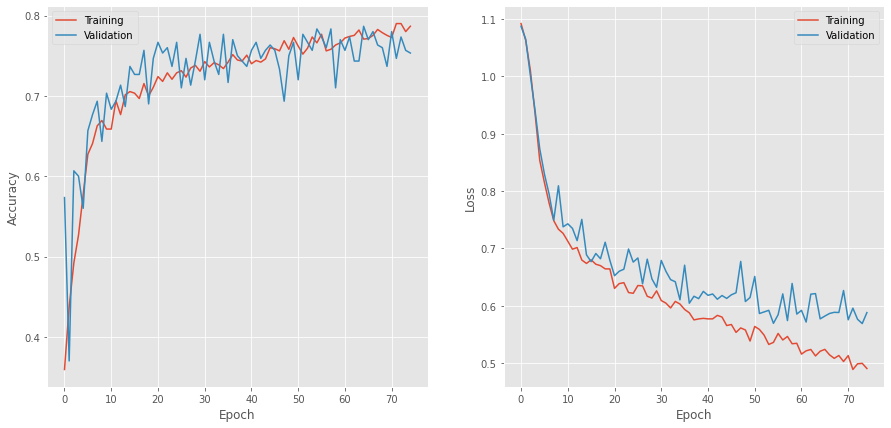

In [680]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.889     0.964     0.925       500
    BACTERIA      0.708     0.860     0.777       500
       VIRUS      0.818     0.574     0.675       500

    accuracy                          0.799      1500
   macro avg      0.805     0.799     0.792      1500
weighted avg      0.805     0.799     0.792      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.836     0.970     0.898       100
    BACTERIA      0.678     0.800     0.734       100
       VIRUS      0.742     0.490     0.590       100

    accuracy                          0.753       300
   macro avg      0.752     0.753     0.741       300
weighted avg      0.752     0.753     0.741       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.871     0.838     0.854       234
    BACTERIA      0.803     0.876     

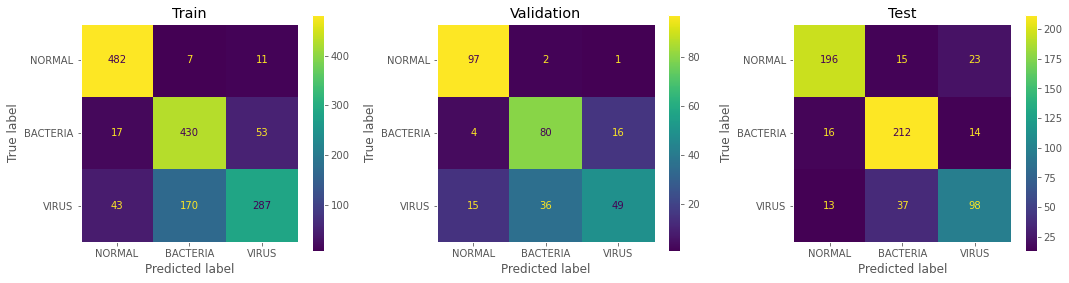

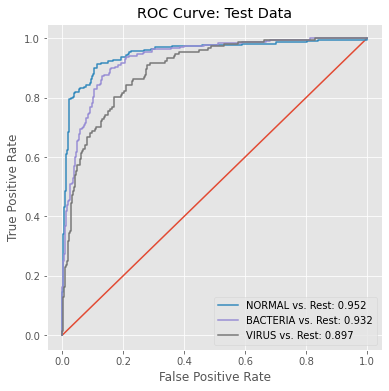

In [681]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

The overfitting has improved compared to Model 3. The overall accuracy also improved, but the performance on VIRAL images went down. I do think it is worth keeping the Dropout layers.

**Model 6**

So far, I have used images that have been downsampled to a size of 129x180. In this model, I will see what happens if I use slightly higher resolution images (172x240). This will definitely make the fitting take longer, so it must provide a good boost in performance to be worthwhile. I do change the first MaxPooling2D kernel from 2x2 to 3x3 to keep the number of parameters from getting a lot higher.

Below, I need to create new images at the desired size.

In [682]:
np.random.seed(42)
# Size of train dataset
train_size = 500
# Size of validation dataset
val_size = 100

# Desired width of images
width = 240
dimensions = (int(np.round(mean_aspect*width,0)), width)

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test = create_tensors(test_list, dimensions, OHE=True)

In [685]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 170, 238, 32)      320       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 56, 79, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 56, 79, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 54, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 27, 38, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 27, 38, 32)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 25, 36, 64)      

In [686]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
47/47 [==============================] - 26s 562ms/step - loss: 1.0966 - acc: 0.3587 - val_loss: 1.0874 - val_acc: 0.5167
Epoch 2/75
47/47 [==============================] - 25s 536ms/step - loss: 1.0663 - acc: 0.4300 - val_loss: 1.0593 - val_acc: 0.6033
Epoch 3/75
47/47 [==============================] - 26s 547ms/step - loss: 1.0063 - acc: 0.4867 - val_loss: 1.0111 - val_acc: 0.5033
Epoch 4/75
47/47 [==============================] - 26s 548ms/step - loss: 0.9443 - acc: 0.5480 - val_loss: 0.9422 - val_acc: 0.5933
Epoch 5/75
47/47 [==============================] - 26s 563ms/step - loss: 0.8593 - acc: 0.5793 - val_loss: 0.8518 - val_acc: 0.5933
Epoch 6/75
47/47 [==============================] - 26s 549ms/step - loss: 0.8171 - acc: 0.6027 - val_loss: 0.8138 - val_acc: 0.6500
Epoch 7/75
47/47 [==============================] - 26s 550ms/step - loss: 0.7734 - acc: 0.6200 - val_loss: 0.7770 - val_acc: 0.6867
Epoch 8/75
47/47 [==============================] - 25s 540ms/step - 

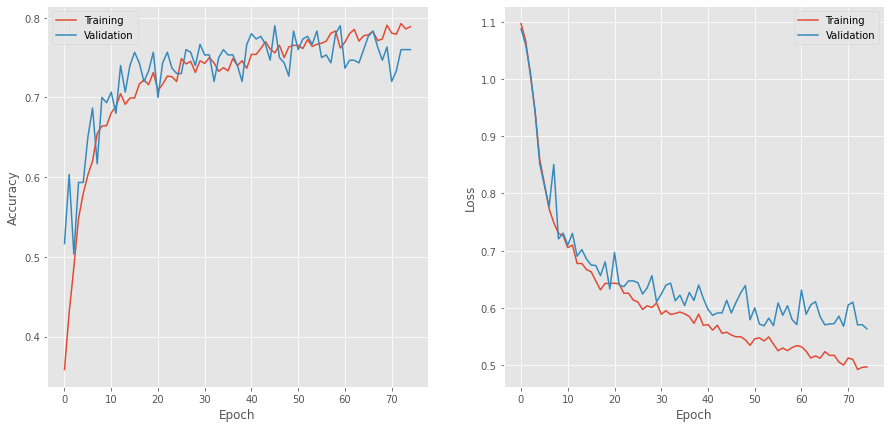

In [687]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.896     0.968     0.931       500
    BACTERIA      0.743     0.832     0.785       500
       VIRUS      0.797     0.638     0.709       500

    accuracy                          0.813      1500
   macro avg      0.812     0.813     0.808      1500
weighted avg      0.812     0.813     0.808      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.851     0.970     0.907       100
    BACTERIA      0.710     0.760     0.734       100
       VIRUS      0.696     0.550     0.615       100

    accuracy                          0.760       300
   macro avg      0.752     0.760     0.752       300
weighted avg      0.752     0.760     0.752       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.877     0.850     0.863       234
    BACTERIA      0.812     0.822     

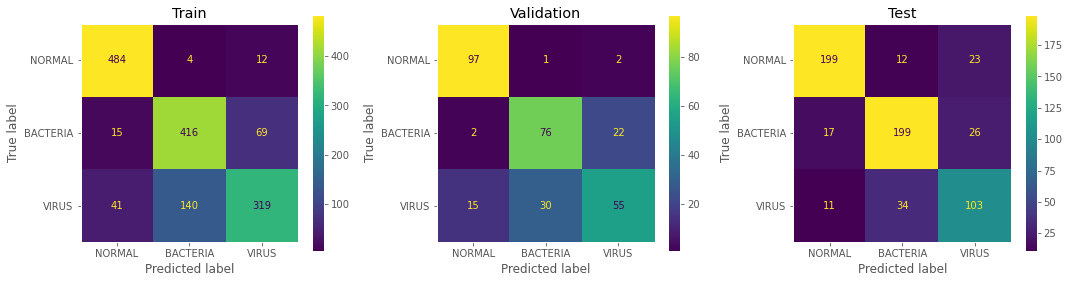

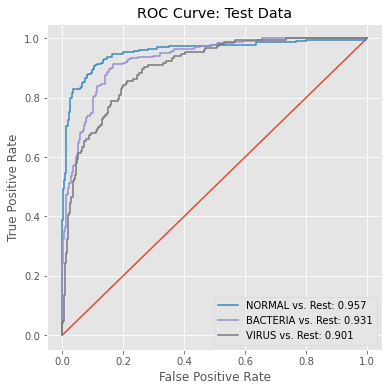

In [688]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Increasing the resolution did not improve the performance. The accuracy of the test data was actually a little worse.

**Model 7**

So far, I have used a sample of 1500 images for the train data. I want to see if increasing the sample size significantly improves the fits. I will try having 2400 images.

I will go back to have 129x180 input images.

In [689]:
np.random.seed(42)
# Size of train dataset
train_size = 800
# Size of validation dataset
val_size = 160

# Desired width of images
width = 180
dimensions = (int(np.round(mean_aspect*width,0)), width)

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test = create_tensors(test_list, dimensions, OHE=True)

In [690]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 28, 41, 64)      

In [691]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
75/75 [==============================] - 37s 495ms/step - loss: 1.0903 - acc: 0.3979 - val_loss: 1.0822 - val_acc: 0.5813
Epoch 2/75
75/75 [==============================] - 36s 484ms/step - loss: 1.0275 - acc: 0.4829 - val_loss: 0.9980 - val_acc: 0.5375
Epoch 3/75
75/75 [==============================] - 36s 477ms/step - loss: 0.9290 - acc: 0.5421 - val_loss: 0.9107 - val_acc: 0.5396
Epoch 4/75
75/75 [==============================] - 36s 479ms/step - loss: 0.8301 - acc: 0.5775 - val_loss: 0.8035 - val_acc: 0.6021
Epoch 5/75
75/75 [==============================] - 36s 479ms/step - loss: 0.7914 - acc: 0.6158 - val_loss: 0.7812 - val_acc: 0.6167
Epoch 6/75
75/75 [==============================] - 36s 477ms/step - loss: 0.7561 - acc: 0.6350 - val_loss: 0.7721 - val_acc: 0.6271
Epoch 7/75
75/75 [==============================] - 36s 476ms/step - loss: 0.7354 - acc: 0.6587 - val_loss: 0.7279 - val_acc: 0.6604
Epoch 8/75
75/75 [==============================] - 36s 481ms/step - 

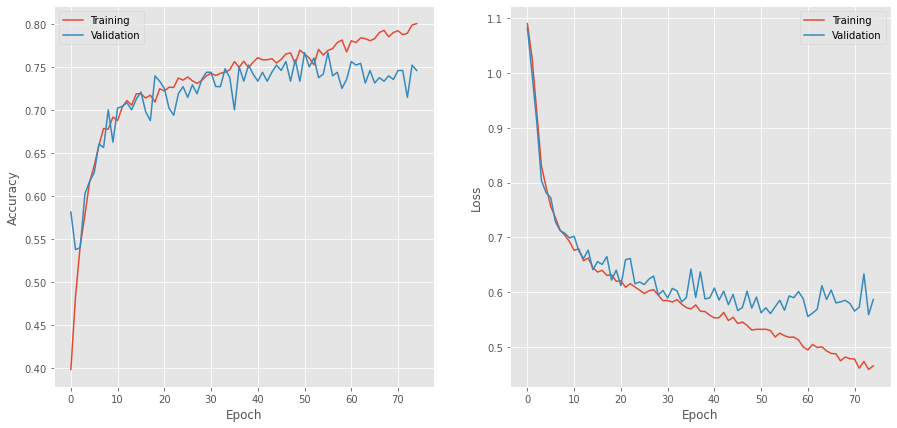

In [692]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.874     0.985     0.926       800
    BACTERIA      0.717     0.873     0.787       800
       VIRUS      0.851     0.557     0.674       800

    accuracy                          0.805      2400
   macro avg      0.814     0.805     0.796      2400
weighted avg      0.814     0.805     0.796      2400

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.826     0.981     0.897       160
    BACTERIA      0.654     0.838     0.734       160
       VIRUS      0.788     0.419     0.547       160

    accuracy                          0.746       480
   macro avg      0.756     0.746     0.726       480
weighted avg      0.756     0.746     0.726       480

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.886     0.868     0.877       234
    BACTERIA      0.795     0.897     

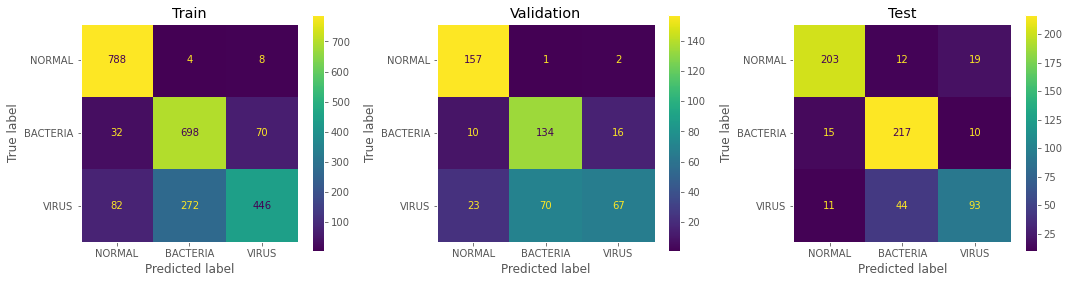

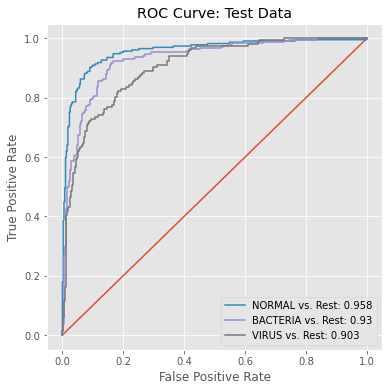

In [693]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Using more data did not actually improve the results much. Adding more data was not worth the increase in fitting time.

**Model 8**

I

In [694]:
np.random.seed(42)
# Size of train dataset
train_size = 500
# Size of validation dataset
val_size = 100

# Desired width of images
width = 180
dimensions = (int(np.round(mean_aspect*width,0)), width)

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test = create_tensors(test_list, dimensions, OHE=True)

In [699]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 63, 89, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 30, 43, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 28, 41, 64)      

In [700]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=75,
                    batch_size=32,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/75
47/47 [==============================] - 24s 514ms/step - loss: 1.1393 - acc: 0.3700 - val_loss: 1.0662 - val_acc: 0.3800
Epoch 2/75
47/47 [==============================] - 25s 534ms/step - loss: 0.9292 - acc: 0.5107 - val_loss: 0.8398 - val_acc: 0.6467
Epoch 3/75
47/47 [==============================] - 26s 551ms/step - loss: 0.7974 - acc: 0.6180 - val_loss: 0.7806 - val_acc: 0.6700
Epoch 4/75
47/47 [==============================] - 26s 546ms/step - loss: 0.7231 - acc: 0.6673 - val_loss: 0.6805 - val_acc: 0.6900
Epoch 5/75
47/47 [==============================] - 25s 528ms/step - loss: 0.6869 - acc: 0.6840 - val_loss: 0.7108 - val_acc: 0.7000
Epoch 6/75
47/47 [==============================] - 25s 529ms/step - loss: 0.6578 - acc: 0.7020 - val_loss: 0.6771 - val_acc: 0.7067
Epoch 7/75
47/47 [==============================] - 25s 530ms/step - loss: 0.6355 - acc: 0.7200 - val_loss: 0.7369 - val_acc: 0.6833
Epoch 8/75
47/47 [==============================] - 26s 555ms/step - 

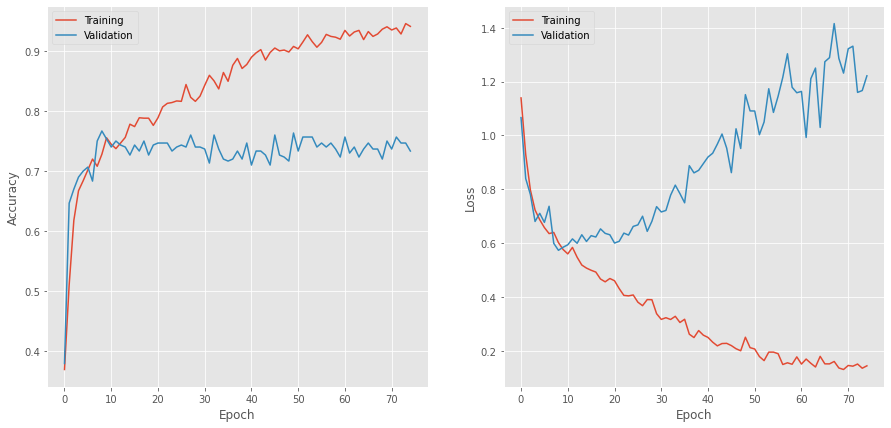

In [703]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.998     0.998     0.998       500
    BACTERIA      0.982     0.998     0.990       500
       VIRUS      0.996     0.980     0.988       500

    accuracy                          0.992      1500
   macro avg      0.992     0.992     0.992      1500
weighted avg      0.992     0.992     0.992      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.853     0.930     0.890       100
    BACTERIA      0.688     0.660     0.673       100
       VIRUS      0.642     0.610     0.626       100

    accuracy                          0.733       300
   macro avg      0.728     0.733     0.730       300
weighted avg      0.728     0.733     0.730       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.924     0.829     0.874       234
    BACTERIA      0.880     0.727     

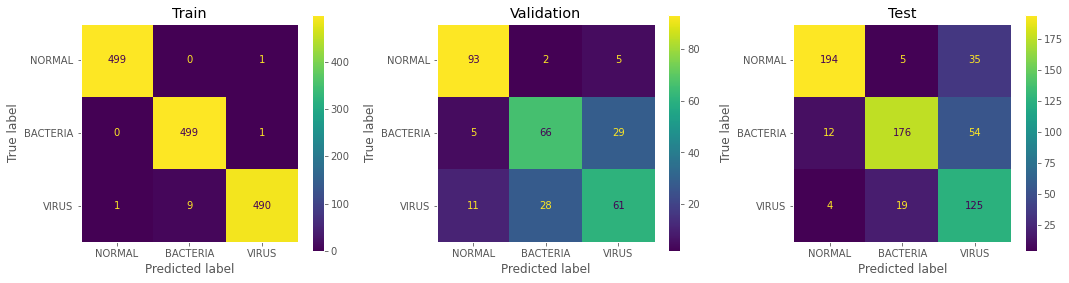

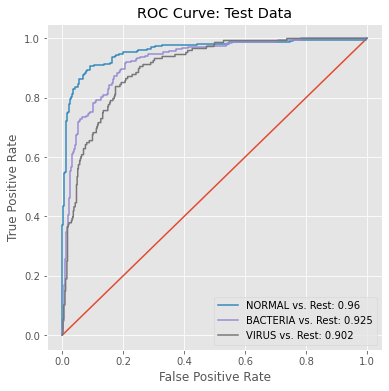

In [704]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Using rmsprop as the optimizer led to significant overfitting.

Things I can adjust to improve the model:

Change input:
Change size of input image
Change number of input images used

Change architecture:
Add/subtract layers
Increase number of filters/nodes in a layer
Change optimizer

Model:
Change number of epochs
Change batch size

Regularization:
Add kernel regularization
Add dropout layers

### Evaluation

<table>
  <tr>
    <th></th>
    <th></th>
    <th>Train</th>
    <th>Train</th>
    <th>Train</th>
    <th>Train</th>
    <th>Test</th>
    <th>Test</th>
    <th>Test</th>
    <th>Test</th>
    <th colspan="3">ROC AUC</th>
    <th>Time</th>
  </tr>
  <tr>
    <th>Model</th>
    <th>Description</th>
    <th>Accuracy</th>
    <th>Recall (Healthy)</th>
    <th>Recall (Bacteria)</th>
    <th>Recall (Viral)</th>
    <th>Accuracy</th>
    <th>Recall (Healthy)</th>
    <th>Recall (Bacteria)</th>
    <th>Recall (Viral)</th>
    <th>Healthy</th>
    <th>Bacterial</th>
    <th>Viral</th>
    <th>(s)</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Baseline</td>
    <td>79.8%</td><td>93.4%</td><td>77.4%</td><td>67.6%</td>
    <td>79.5%</td><td>82.9%</td><td>79.8%</td><td>75%</td>
    <td>0.954</td><td>0.937</td><td>0.911</td>
    <td>677</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Model 1 + Third Conv2D layer</td>
    <td>79.1%</td><td>95.2%</td><td>84.0%</td><td>58.0%</td>
    <td>81.1%</td><td>84.2%</td><td>87.2%</td><td>66.2%</td>
    <td>0.951</td><td>0.933</td><td>0.909</td>
    <td>992</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Model 2 with 75 epochs</td>
    <td>90.1%</td><td>98.4%</td><td>81.4%</td><td>90.6%</td>
    <td>79.8%</td><td>84.2%</td><td>75.2%</td><td>80.4%</td>
    <td>0.955</td><td>0.933</td><td>0.914</td>
    <td>1463</td>
  <tr>
    <td>4</td>
    <td>Model 3 with L2 regularization</td>
    <td>88.9%</td><td>96.4%</td><td>81.8%</td><td>88.6%</td>
    <td>78.4%</td><td>79.5%</td><td>76.9%</td><td>79.1%</td>
    <td>0.955</td><td>0.933</td><td>0.908</td>
    <td>1499</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Model 3 + Dropout layers</td>
    <td>79.9%</td><td>96.4%</td><td>86.0%</td><td>57.4%</td>
    <td>81.1%</td><td>83.8%</td><td>87.6%</td><td>66.2%</td>
    <td>0.952</td><td>0.932</td><td>0.897</td>
    <td>1854</td>
  </tr>
  <tr>
    <td>6</td>
    <td>Model 5 with 172x240 input</td>
    <td>81.3%</td><td>96.8%</td><td>83.2%</td><td>63.8%</td>
    <td>80.3%</td><td>85.0%</td><td>82.2%</td><td>69.6%</td>
    <td>0.957</td><td>0.931</td><td>0.901</td>
    <td>1923</td>
  </tr>
  <tr>
    <td>7</td>
    <td>Model 5 with 2400 input images</td>
    <td>80.5%</td><td>98.5%</td><td>87.3%</td><td>55.7%</td>
    <td>82.2%</td><td>86.8%</td><td>89.7%</td><td>62.8%</td>
    <td>0.958</td><td>0.93</td><td>0.903</td>
    <td>2764</td>
  </tr>
  <tr>
    <td>8</td>
    <td>Model 5 with rmsprop optimizer</td>
    <td>80.5%</td><td>98.5%</td><td>87.3%</td><td>55.7%</td>
    <td>82.2%</td><td>86.8%</td><td>89.7%</td><td>62.8%</td>
    <td>0.958</td><td>0.93</td><td>0.903</td>
    <td>2764</td>
  </tr>
</table>